##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bert_experts"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で実行</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/bert_experts.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/bert_experts.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/bert_experts.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
  <td>     <a href="https://tfhub.dev/s?q=experts%2Fbert"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub モデルを参照</a>   </td>
</table>

# TF-Hub の BERT エキスパート

この Colab では、以下の方法を実演します。

- MNLI、SQuAD、PubMed など、さまざまなタスクでトレーニング済みの BERT モデルを [TensorFlow Hub](https://tfhub.dev) から読み込みます。
- 一致する事前処理モデルを使用して、未加工のテキストをトークン化して ID に変換します。
- 読み込んだモデルを使用して、トークン入力 ID からプールされたシーケンス出力を生成します。
- 異なる文のプールされた出力に見られる意味的類似性を確認します。

#### 注意: この Colab の実行には GPU ランタイムを使用してください。

## セットアップとインポート

In [2]:
!pip install --quiet "tensorflow-text==2.11.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [3]:
import seaborn as sns
from sklearn.metrics import pairwise

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

2024-01-11 17:45:23.919485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


2024-01-11 17:45:24.594701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-11 17:45:24.594803: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-11 17:45:24.594813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## 文章

Wikipedia から取得した、モデルで実行するための文章を見てみましょう。

In [5]:
sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Among the singles released from the album were the songs \"Be My Lover\" and \"Hard To Stay Awake\".",
  "Riccardo Zegna is an Italian jazz musician.",
  "Rajko Maksimović is a composer, writer, and music pedagogue.",
  "One of the most significant Serbian composers of our time, Maksimović has been and remains active in creating works for different ensembles.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]

## モデルの実行

TF-Hub から BERT モデルを読み込み、TF-Hub の一致する事前処理モデルを使用して文章をトークン化し、そのトークン化された文章をモデルにフィードします。この Colab を端的に進められるよう、GPU で実行することをお勧めします。

**Runtime** → **Change runtime type** に移動して、**GPU** が選択されていることを確認します。

In [6]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)
inputs = preprocess(sentences)
outputs = bert(inputs)

2024-01-11 17:45:26.405563: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-11 17:45:26.405718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-11 17:45:26.405800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-11 17:45:26.405886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-01-11 17:45:26.470673: W tensorfl

In [7]:
print("Sentences:")
print(sentences)

print("\nBERT inputs:")
print(inputs)

print("\nPooled embeddings:")
print(outputs["pooled_output"])

print("\nPer token embeddings:")
print(outputs["sequence_output"])

Sentences:
["Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.", 'The album went straight to number one on the Norwegian album chart, and sold to double platinum.', 'Among the singles released from the album were the songs "Be My Lover" and "Hard To Stay Awake".', 'Riccardo Zegna is an Italian jazz musician.', 'Rajko Maksimović is a composer, writer, and music pedagogue.', 'One of the most significant Serbian composers of our time, Maksimović has been and remains active in creating works for different ensembles.', 'Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum', 'A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.', "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth."]

BERT inputs:
{'input_type_

## 意味的類似性

では、文章の `pooled_output` 埋め込みを確認し、文章間でどれくらい類似性があるのかを比較しましょう。

In [8]:
#@title Helper functions

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = pairwise.cosine_similarity(features)
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, cmap="Blues", cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

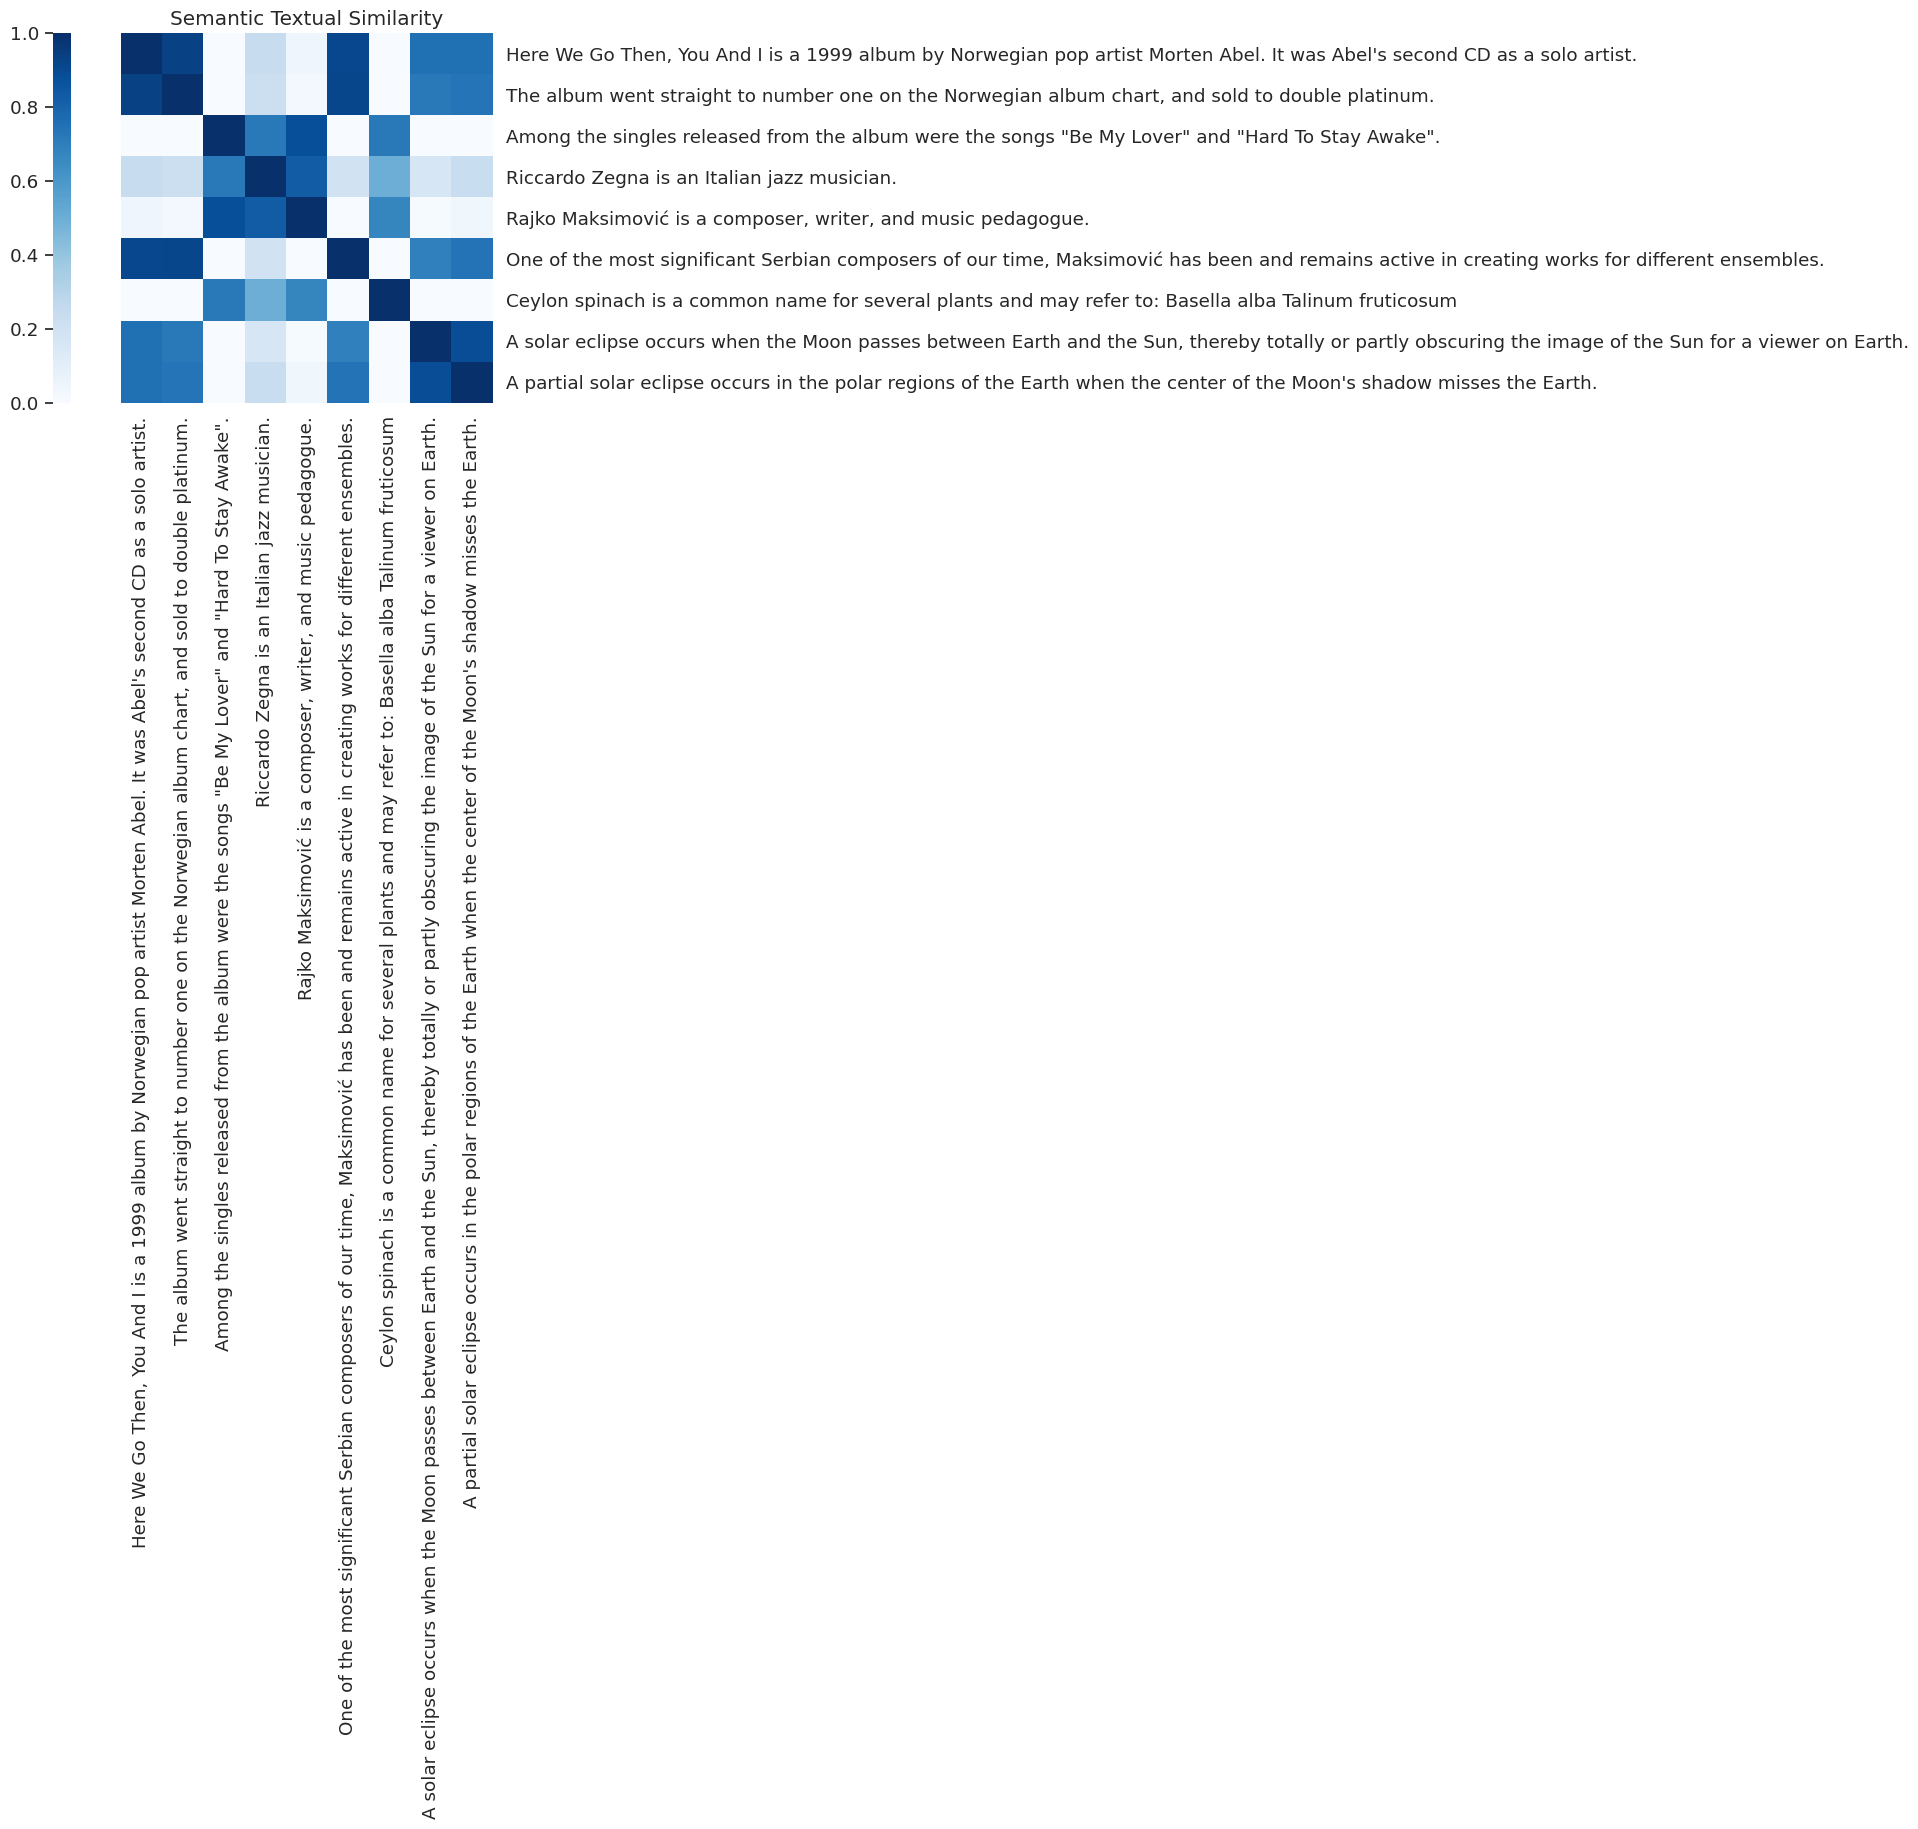

In [9]:
plot_similarity(outputs["pooled_output"], sentences)

## 詳細情報

- その他の BERT モデルは、[TensorFlow Hub](https://tfhub.dev) をご覧ください。
- このノートブックでは BERT を使った単純な推論を実演しています。BERT のファインチューニングに関するより高度なチュートリアルについては、[tensorflow.org/official_models/fine_tuning_bert](https://www.tensorflow.org/official_models/fine_tuning_bert) をご覧ください。
- モデルの実行には、GPU チップを 1 つしか使用していません。tf.distribute を使ったモデルの読み込み方法については、[tensorflow.org/tutorials/distribute/save_and_load](https://www.tensorflow.org/tutorials/distribute/save_and_load) をご覧ください。